In [1]:
from pyspark.sql.functions import mean, udf, col, round, isnan, when, count
from pyspark.sql.types import DoubleType
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import datetime 
print(datetime.datetime.now())
%matplotlib inline

sc = SparkContext('local')
spark = SparkSession(sc)

2019-05-29 18:05:08.371121


In [2]:
spark_session  = SparkSession.builder\
                        .enableHiveSupport()\
                        .getOrCreate()

spark_session.conf.set("spark.executor.memory", '8g')
spark_session.conf.set('spark.executor.cores', '13')
spark_session.conf.set('spark.cores.max', '13')
spark_session.conf.set("spark.driver.memory",'8g')
sc = spark_session.sparkContext

## import csv files into spark dataframes
Note: both files contain records from all 5 boroughs

In [12]:
BK = spark.read.csv('data/18v1/BK_18v1.csv', header=True)
BX = spark.read.csv('data/18v1/BX_18v1.csv', header=True)
MN = spark.read.csv('data/18v1/MN_18v1.csv', header=True)
QN = spark.read.csv('data/18v1/QN_18v1.csv', header=True)
SI = spark.read.csv('data/18v1/SI_18v1.csv', header=True)

df1 = spark.read.csv('data/pluto_19v1.csv', header=True)
df2 = spark.read.csv('data/pluto_18v2_1.csv', header=True)
df3 = BK.union(BX).union(MN).union(QN).union(SI)

In [13]:
df1 = df1.select([col(A).alias(A.lower()) for A in df1.schema.names])
df2 = df2.select([col(A).alias(A.lower()) for A in df2.schema.names])
df3 = df3.select([col(A).alias(A.lower()) for A in df3.schema.names])

In [14]:
double_columns = ['bldgarea', 'facilfar',
                  'residfar', 'commfar', 'numbldgs', 'numfloors', 'bldgdepth', 
                  'bldgfront', 'lotdepth', 'lotfront', 
                  'exempttot', 'exemptland',  'assessland', 'assesstot', 'builtfar']

In [15]:
cols = df2.columns

In [21]:
df1 = df1.select(cols)
df2 = df2.select(cols)
df3 = df3.select(cols)

## Type Conversion

In [22]:
for A in double_columns: 
    df1 = df1.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df2 = df2.withColumn(A, round(col(A).cast(DoubleType()), 2))
    df3 = df3.withColumn(A, round(col(A).cast(DoubleType()), 2))

## Count Null and 0

In [23]:
null_1 = df1.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df1.columns]).toPandas()

In [24]:
null_2 = df2.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df2.columns]).toPandas()

In [25]:
null_3 = df3.select([(count(when(isnan(c) | col(c).isNull(), 1))\
                      + count(when(col(c)==0,1))).alias(c) for c in df3.columns]).toPandas()

In [26]:
null_all = pd.concat([null_3, null_2, null_1])
null_change = null_all.pct_change()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [27]:
null_change.iloc[1,:].sort_values(ascending=False)[0:10]

bbl                inf
borocode           inf
cd                 inf
lot                inf
version            inf
plutomapid         inf
block         7.000000
zonemap       6.359684
zipcode       3.944872
zonedist1     3.865060
Name: 0, dtype: float64

In [28]:
null_change.iloc[2,:].sort_values(ascending=False)[0:10]

address       54.535985
plutomapid     9.782051
lotfront       2.888962
lotarea        2.374782
lotdepth       1.443626
ownername      1.437700
taxmap         1.310773
sanitsub       1.309392
tract2010      0.957000
sanborn        0.956044
Name: 0, dtype: float64

In [29]:
null_all.index = ['18v1', '18v2', '19v1']
null_all

,address,appbbl,appdate,areasource,assessland,assesstot,basempdate,bbl,bldgarea,bldgclass,...,yearalter2,yearbuilt,zipcode,zmcode,zonedist1,zonedist2,zonedist3,zonedist4,zonemap,zoningdate
18v1,510,768685,768684,812,4560,4560,NaN,0,43195,487,...,845153,44726,4154,843698,415,833485,858862,859192,253,NaN
18v2,528,767446,767425,730,4291,4291,6.0,6,44149,475,...,843687,44607,20541,843111,2019,839136,858787,858969,1862,6.0
19v1,29323,768118,768119,1262,5250,5249,1.0,1,44663,591,...,846579,53017,21489,844052,3112,840046,859730,859917,2958,1.0


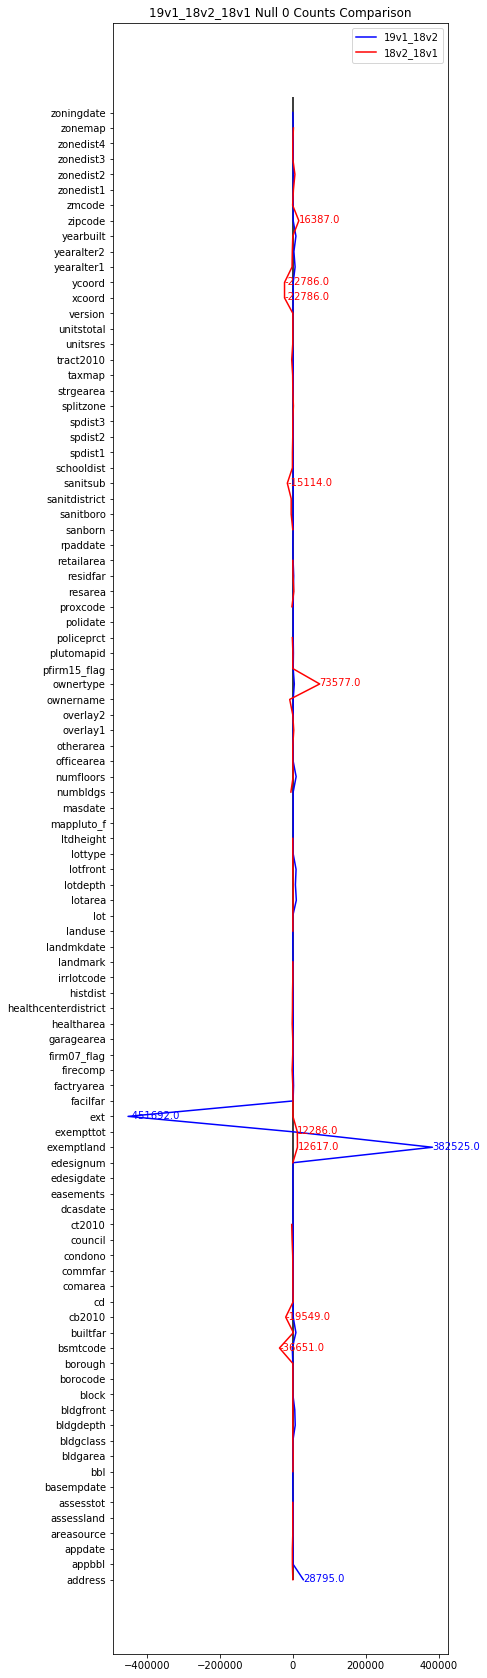

In [40]:
plt.figure(figsize=(6, 30))

difference1 = null_all.iloc[1, :]-null_all.iloc[0, :]
difference2 = null_all.iloc[2, :]-null_all.iloc[1, :]

plt.plot(difference2, range(96), label = '19v1_18v2', color = 'blue')
plt.plot(difference1, range(96), label = '18v2_18v1', color = 'red')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(difference2[i]) >= 10000:
        plt.text(x = difference2[i] , y = i - 0.15, s = '{}'.format(difference2[i]), size = 10, color = 'blue')
    else: 
        pass
    
for i in range(96):
    if abs(difference1[i]) >= 10000:
        plt.text(x = difference1[i] , y = i-0.15, s = '{}'.format(difference1[i]), size = 10, color = 'red')
    else: 
        pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
plt.title('19v1_18v2_18v1 Null 0 Counts Comparison')
plt.legend()
plt.savefig('19v1_18v2_18v1_Null0_Comparison.png', bbox_inches='tight')
plt.show()

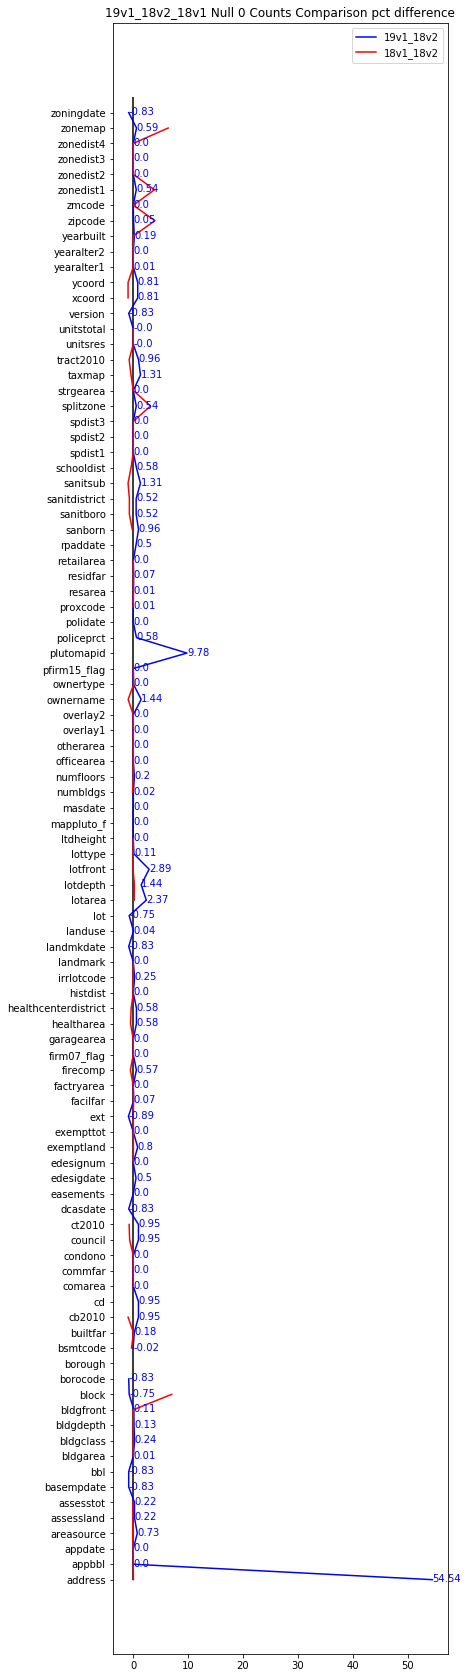

In [41]:
plt.figure(figsize=(6, 30))

plt.plot(null_change.iloc[2,:], range(96), label = '19v1_18v2', color = 'blue')
plt.plot(null_change.iloc[1,:], range(96), label = '18v1_18v2', color = 'red')
plt.vlines(0, 0, 96) #0 reference line

for i in range(96):
    if abs(null_change.iloc[2,i]) <= 100:
        plt.text(x = null_change.iloc[2,i] , y = i - 0.15, s = '{}'.format(np.round(null_change.iloc[2,i], 2)), size = 10, color = 'blue')
    else: 
        pass
    
plt.yticks(range(96), null_all.columns, rotation='horizontal')
plt.title('19v1_18v2_18v1 Null 0 Counts Comparison pct difference')
plt.legend()
plt.savefig('19v1_18v2_18v1_Null0_Comparison_pct.png', bbox_inches='tight')
plt.show()